**Forensic Scanner Identification Using CASIA Datasets**

Datasets
[CASIA2](https://drive.google.com/drive/folders/1p--NIVEPSBiQKGlrr_OrDydD1JXKoUTG?usp=sharing)
[CASIA1](https://drive.google.com/drive/folders/1vnyghsrVytqNvAqCDnkx1409UCKodenu?usp=sharing)

Mounting the Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the Packages**

In [33]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from pylab import *
from PIL import Image, ImageChops, ImageEnhance

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


Function to get list of images in folder path

In [35]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

**Converting the images to Error Level Analysis**

In [36]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

Exploring the Image Data

In [37]:
from tqdm import tqdm
path_original = '/content/drive/MyDrive/casia/CASIA2/Au/'
path_tampered = '/content/drive/MyDrive/casia/CASIA2/Tp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [38]:
images = []

for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)

100%|██████████| 7492/7492 [00:01<00:00, 5576.44it/s]


In [39]:
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)

100%|██████████| 5124/5124 [00:00<00:00, 5328.92it/s]


In [40]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 12389/12389 [00:00<00:00, 511877.38it/s]


**Feature Extraction using Dataframe**

In [41]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})
dataset.to_csv('/content/drive/MyDrive/casia/dataset.csv',index=False)
dataset = pd.read_csv('/content/drive/MyDrive/casia/dataset.csv')

In [42]:
X = []
Y = []

In [43]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((60, 60))).flatten() / 255.0)
    Y.append(row[1])

X = np.array(X)
Y = to_categorical(Y, 2)

In [44]:
X = X.reshape(-1, 60, 60, 3)

Splitting  the Datas 

In [45]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

**Deploying the CNN**

In [46]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu', input_shape = (60,60,3)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'valid',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(60, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        1216      
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 26, 26, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 dense_2 (Dense)             (None, 60)                649020    
                                                      

In [48]:
from keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, Y_train, batch_size = 100, epochs = 5,validation_data = (X_val, Y_val), verbose = 2)

**Generating the Model File**

In [49]:
model.save('/content/drive/MyDrive/casia/detector.h5')

Precision And Re-call score for the Model

In [ ]:
from sklearn import metrics
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1) 

score = metrics.precision_score(Y_true,y_pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred, average= "weighted")
print("Recall score: {}".format(score))
score_f1 = metrics.f1_score(Y_true, y_pred, average= "weighted")
print("F1 score: {}".format(score_f1))

78/78 [==============================] - 5s 64ms/step
Precision score: 0.44722825411703887
Recall score: 0.5964487489911219
F1 score: 0.4631673140276141


In [ ]:
cm = confusion_matrix(Y_true, y_pred)
print('Confusion matrix:\n',cm)

Confusion matrix:
 [[1467   44]
 [ 956   11]]


Prediction With the Model for the input Image

In [ ]:
path_original = '/content/drive/MyDrive/casia/CASIA1/Au/Au_arc_0006.jpg'
path_tampered = '/content/drive/MyDrive/casia/CASIA1/Sp/Sp_D_NRN_A_cha0049_cha0048_0496.jpg'

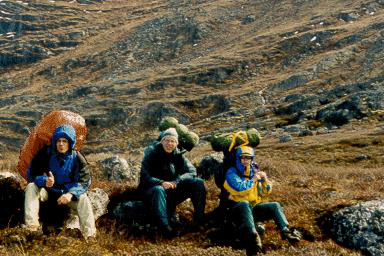

In [ ]:
orig_img = Image.open('/content/drive/MyDrive/casia/CASIA1/Sp/Sp_D_NRN_A_cha0049_cha0048_0496.jpg')
display(orig_img)

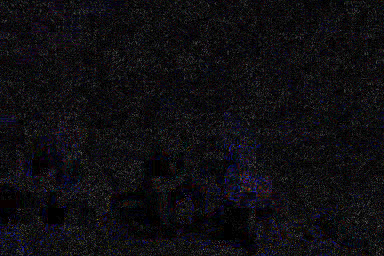

In [ ]:
convert_to_ela_image('/content/drive/MyDrive/casia/CASIA1/Sp/Sp_D_NRN_A_cha0049_cha0048_0496.jpg',90)

In [ ]:
X_f = []

In [ ]:
X_f.append(np.array(convert_to_ela_image(path_tampered,90).resize((60, 60))).flatten() / 255.0)

In [ ]:
X_f = np.array(X_f)

In [ ]:
X_f = X_f.reshape(-1, 60, 60, 3)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/casia/detector.h5')

In [ ]:
y_pred_test = model.predict(X_f)
y_pred_test = np.argmax(y_pred_test,axis = 1)

1/1 [==============================] - 0s 164ms/step


In [ ]:
print(y_pred_test)

[0]
